# 데이터 전처리 및 모델 학습 코드
* masking value는 sst 전체의 mean, epochs는 20인 모델 기준

## 라이브러리 불러오기

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv3D, ConvLSTM2D, BatchNormalization
from keras import callbacks

## 데이터 불러오기

In [3]:
official_data_path = './official_data/'
our_data_path = './val_test_data/'

In [4]:
xr_raw_sst = xr.open_dataset(official_data_path+'sst.anom.mon.mean.nc')
# xr_raw_sst = xr.open_dataset(official_data_path+'sst.anom.mon.mean.nc', decode_times=False)

d:\anaconda3\envs\final_sealab\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


## 데이터 전처리

xarray를 numpy로 변경

In [5]:
np_raw_sst = xr_raw_sst['sst'].data

In [6]:
print(type(np_raw_sst))
print(np_raw_sst.shape)
print(np_raw_sst.dtype)

<class 'numpy.ndarray'>
(499, 180, 360)
float32


채널 정보 추가

In [7]:
data = np.expand_dims(np_raw_sst, axis = -1)

In [8]:
print(data.shape)

(499, 180, 360, 1)


연 단위로 데이터를 끊기 위해 앞의 7개월(1982/01~1982/07) 제거


In [9]:
data = data[7:]
print(data.shape)

(492, 180, 360, 1)


육지에 해당하는 위경도값에는 nan 값이 들어가 있으므로 이를 적절한 값(본 코드에서는 평균)으로 대체

In [10]:
mask_value = np.nanmean(np_raw_sst)
data = np.where(np.isnan(data), mask_value, data)

월별 데이터로 분리

In [11]:
data_month = []

for i in range(12):
    data_month.append(data[i::12, :,:])

data_month = np.array(data_month)

print(data_month.shape)

(12, 41, 180, 360, 1)


4년 단위로 학습하고 추후 1년을 예측하도록 x, y 구분

In [12]:
window_size = 4

x_data = []
y_data = []

for i in range(data_month.shape[1]-window_size):
    x_data.append(data_month[:, i:i+window_size, :,:,:])
    y_data.append(data_month[:, i+window_size:i+window_size+1, :,:,:])

x_data = np.array(x_data)
y_data = np.array(y_data)

print(x_data.shape, y_data.shape)

(37, 12, 4, 180, 360, 1) (37, 12, 1, 180, 360, 1)


2023년 8월부터 2024년 7월까지의 IOD 예측을 위한 test set 설정

In [13]:
x_test = data_month[:, 37:41, ...]
x_test.shape

(12, 4, 180, 360, 1)

추후 예측을 위해 test set을 npy 파일로 저장

In [14]:
# np.save(our_data_path + 'test.npy', x_test)
np.save(our_data_path + 'demo_test.npy', x_test)

# 불러오기
# load_test = np.load(our_data_path + 'test.npy')

train, validation 데이터 분리


In [15]:
# train
x_train = []
y_train = []
for t in range(x_data.shape[0]):
    for m in range(12):
        x = x_data[t, m, ...]
        y = y_data[t, m, ...]
        x_train.append(x)
        y_train.append(y)

x_train = np.array(x_train)
y_train = np.array(y_train)

# validation
x_val = []
y_val = []

for m in range(12):
    x = x_data[-1, m, ...]
    y = y_data[-1, m, ...]
    x_val.append(x)
    y_val.append(y)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [16]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(444, 4, 180, 360, 1) (444, 1, 180, 360, 1) (12, 4, 180, 360, 1) (12, 1, 180, 360, 1)


추후 모델 평가를 위해 validation set을 npz 파일로 저장

In [17]:
# np.savez(our_data_path + 'xy_val.npz', x_val = x_val, y_val = y_val)
np.savez(our_data_path + 'demo_xy_val.npz', x_val = x_val, y_val = y_val)

# 불러오기
# xy_val = np.load(our_data_path + 'xy_val.npz')
# x_val = xy_val['x_val']
# y_val = xy_val['y_val']

## 효율적인 학습을 위해 tensorflow Dataset 형태로 변경

In [18]:
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch size는 16으로 선언

In [19]:
batch_size = 16

train_set = train_set.batch(batch_size)
val_set = val_set.batch(batch_size)

## 모델 구성 및 학습

모델 구성

In [20]:
seq = Sequential()
seq.add(ConvLSTM2D(filters=20, kernel_size=3,
                   input_shape=(None, 180, 360, 1),
                    padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=20, kernel_size=3,
                    padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=3,
                activation=None,
                padding='same', data_format='channels_last'))

seq.compile(loss='mean_squared_error', optimizer='adam')

seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 180, 360, 2  15200     
                             0)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 180, 360, 2  80       
 ormalization)               0)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 180, 360, 2  28880     
                             0)                                  
                                                                 
 batch_normalization_1 (Batc  (None, None, 180, 360, 2  80       
 hNormalization)             0)                                  
                                                                 
 conv3d (Conv3D)             (None, None, 180, 360, 1  5

모델 저장 경로 및 저장될 이름 선언

In [21]:
model_path = './models/'
model_name = 'demo_maskmean_epochs20.h5'

callback 함수 및 epochs 정의

In [23]:
# validation loss가 가장 낮은 모델을 저장하는 callback 함수 선언
my_callbacks = [callbacks.ModelCheckpoint(
    filepath = model_path + model_name,
    monitor='val_loss',
    save_best_only=True
)]

# 반복 횟수 선언
epochs = 20

모델 학습

In [24]:
# 모델 학습
hist = seq.fit(train_set, epochs=epochs, validation_data=val_set, callbacks=my_callbacks)

# 로컬에서 돌아가긴 한다는 것을 확인

Epoch 1/20
 1/28 [>.............................] - ETA: 2:49:45 - loss: 1.4202

In [ ]:
# 모델 학습
# hist = seq.fit(train_set, epochs=epochs, validation_data=val_set, callbacks=my_callbacks)

# 학습의 경우 리소스 문제로 인해 로컬이 아닌 구글 Colab 환경에서 실행했습니다.

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 0.4847

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 62s 1s/step - loss: 0.4847 - val_loss: 0.4758
Epoch 2/20
28/28 [==============================] - 40s 1s/step - loss: 0.3120 - val_loss: 0.4677
Epoch 3/20
28/28 [==============================] - 41s 1s/step - loss: 0.2924 - val_loss: 0.4631
Epoch 4/20
28/28 [==============================] - 41s 1s/step - loss: 0.2872 - val_loss: 0.4594
Epoch 5/20
28/28 [==============================] - 41s 1s/step - loss: 0.2839 - val_loss: 0.4552
Epoch 6/20
28/28 [==============================] - 41s 1s/step - loss: 0.2813 - val_loss: 0.4507
Epoch 7/20
28/28 [==============================] - 41s 1s/step - loss: 0.2788 - val_loss: 0.4460
Epoch 8/20
28/28 [==============================] - 41s 1s/step - loss: 0.2767 - val_loss: 0.4413
Epoch 9/20
28/28 [==============================] - 41s 1s/step - loss: 0.2750 - val_loss: 0.4361
Epoch 10/20
28/28 [==============================] - 41s 1s/step - loss: 0.2734 - val_loss: 0.4299
Epoch 11/20
28/28 [===========

learning curve 시각화

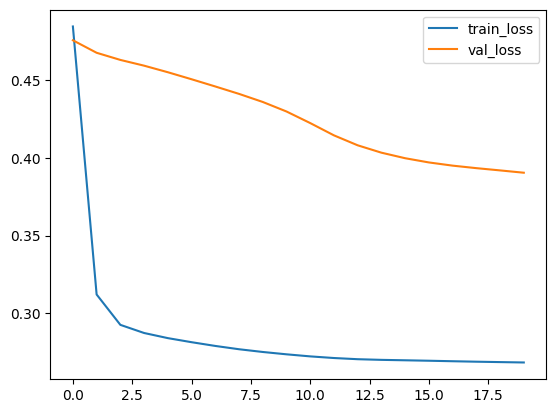

In [ ]:
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

plt.show()